In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings



# Some configrations
pd.options.display.float_format = '{:0.2f}'.format
warnings.filterwarnings('ignore')

sns.set()

In [4]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [23]:
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

In [46]:
# lets drop the 2 columns we used to get the duration

df.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'], inplace=True)

In [30]:
df.duration.describe(percentiles=[0.05, 0.95, 0.98, 0.99])

count   3066766.00
mean         15.67
std          42.59
min         -29.20
5%            3.30
50%          11.52
95%          36.47
98%          48.73
99%          57.25
max       10029.18
Name: duration, dtype: float64

> 99% of the trips are about 57 minutes.. let's save only trips less or equal to 1 hour and more than or equal to 1 minute.

In [31]:
df = df.query('duration <= 60 and duration >= 1')

<Axes: xlabel='duration', ylabel='Density'>

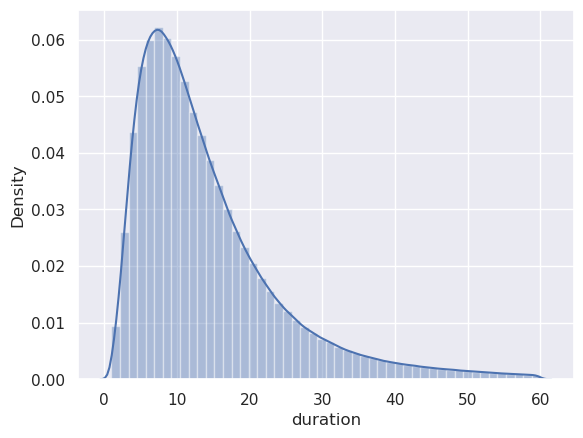

In [36]:
sns.distplot(df.duration)

In [40]:
df.shape

(3009173, 20)

In [47]:
df.isna().sum()

VendorID                 0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
duration                 0
dtype: int64

> There are 71105 rows in 5 columns have no data. lets drop these rows.

In [44]:
df = df.dropna()

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2938068 entries, 0 to 2995022
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   passenger_count        float64
 2   trip_distance          float64
 3   RatecodeID             float64
 4   store_and_fwd_flag     object 
 5   PULocationID           int64  
 6   DOLocationID           int64  
 7   payment_type           int64  
 8   fare_amount            float64
 9   extra                  float64
 10  mta_tax                float64
 11  tip_amount             float64
 12  tolls_amount           float64
 13  improvement_surcharge  float64
 14  total_amount           float64
 15  congestion_surcharge   float64
 16  airport_fee            float64
 17  duration               float64
dtypes: float64(13), int64(4), object(1)
memory usage: 425.9+ MB


In [50]:
df2 = df.select_dtypes(include=np.number)

In [52]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df2.drop(columns='duration'), df2.duration, test_size=0.2)

In [53]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [57]:
y_pred = model.predict(x_test)

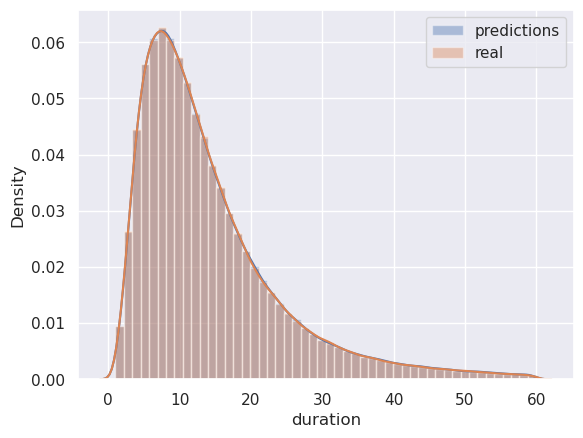

In [63]:
sns.distplot(y_pred, label = 'predictions');
sns.distplot(y_test, label = 'real');

plt.legend();

In [64]:
y_pred

array([8.70, 14.17, 5.32, ..., 38.07, 8.80, 11.70])

In [74]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred, squared=False)

3.233098158048408

> We far from the actual duration with 3 minutes below or apove

In [70]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()

model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [71]:
y_pred_xgb = model_xgb.predict(x_test)

In [73]:
mean_squared_error(y_test, y_pred_xgb, squared=False)

2.3976271602119867

> With XGBoost, we far from the actual values with 2.3 minutes

In [76]:
import pickle
with open('models/xgb_model.bin', 'wb') as file:
    pickle.dump(model_xgb, file)